<a href="https://colab.research.google.com/github/rubygitflow/Glossary-extraction/blob/main/University_of_Artificial_Intelligence_Glossary_extraction_Graduate_work_2020_v_31_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The research project — Glossary extraction

In [124]:
!nvidia-smi

Sun Nov  1 08:06:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |   1067MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Connecting libraries

In [125]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, concatenate, Activation, MaxPooling1D, Conv1D, BatchNormalization, Conv2DTranspose, Lambda, LSTM, GRU, Bidirectional # Импортируем стандартные слои keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from tensorflow.keras.metrics import AUC

from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import collections
%matplotlib inline
import numpy as np # Импортируем библиотеку numpy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report # статистика точности предсказания по классам
import random
import datetime
import time

import xml.etree.ElementTree as ET
import re

import os # Импортируем библиотеку os для работы с фаловой системой
from google.colab import files # Импортируем Модуль files для работы с файлами
from google.colab import drive # Подключаем гугл-диск

In [126]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Segmentation of text

## Reading and verifying data (XML parsing). 



```
# Выбран кодовый формат
```

Ссылки на файлы данных:

База_словарей_test_5.docx : https://drive.google.com/file/d/1077bJ6sdjMDhxpcyL0MEffeP7NFw03wO/view?usp=sharing

База_словарей_train_5.docx : https://drive.google.com/file/d/1fPWdXpZzFe1QtwicjnMWidLuwu8W99jC/view?usp=sharing

База_словарей_test_5.xml : https://drive.google.com/file/d/10XDOqXCuygymFgTmLTFQ5Y17Rpg_DULZ/view?usp=sharing

База_словарей_train_5.xml : https://drive.google.com/file/d/1dBq9vE_3Hxhftwgx40CGFPFVXOBBHM3L/view?usp=sharing


In [127]:
color_meaning = {'00ffff':'термин', 'ffff00':'связка', '00ff00':'определение', 'd3d3d3':'расшифровка', 
                 'ff00ff':'дубль-термин', 'ff0000':'дубль-связка', '808000':'дубль-определение', '0000ff':'дубль-расшифровка',
                 'cyan':'термин','yellow':'связка','green':'определение', 'lightgray':'расшифровка',	                 
                 'magenta':'дубль-термин', 'red':'дубль-связка','darkyellow':'дубль-определение', 'blue':'дубль-расшифровка'}

                 #создаем словарь соответствий цвет-значение   

In [128]:
color_dic = {'термин':0,'связка':1,'определение':2,'расшифровка':3,
			       'дубль-термин':4,'дубль-связка':5,'дубль-определение':6,'дубль-расшифровка':7}

zero_symbol = 'o'

colors_count = len(color_dic) + 1 # количество уникальных тегов (не забываем про тег отсутствия класса для разметки)

skip_amount = colors_count  # кол-во пропускаемых строк под легенду при считывании данных (здесь учитывается, что есть пусая строка, в списке тегов последнее значение используется под отсутствующий класс для разметки)

In [129]:
class color:
  GREY    = '\33[90m'
  RED2    = '\33[91m'
  GREEN2  = '\33[92m'
  YELLOW2 = '\33[93m'
  BLUE2   = '\33[94m'
  VIOLET2 = '\33[95m'
  LI_CYAN = '\33[96m'
  WHITE2  = '\33[97m'

  BLACK  = '\33[30m'
  RED    = '\33[31m'
  GREEN  = '\33[32m'
  YELLOW = '\33[33m'
  BLUE   = '\33[34m'
  VIOLET = '\33[35m'
  CYAN   = '\33[36m'
  WHITE  = '\33[37m'

  GREYBG    = '\33[100m'
  REDBG2    = '\33[101m'
  GREENBG2  = '\33[102m'
  YELLOWBG2 = '\33[103m'
  BLUEBG2   = '\33[104m'
  VIOLETBG2 = '\33[105m'
  LI_CYANBG = '\33[106m'
  WHITEBG2  = '\33[107m'

  BLACKBG  = '\33[40m'
  REDBG    = '\33[41m'
  GREENBG  = '\33[42m'
  YELLOWBG = '\33[43m'
  BLUEBG   = '\33[44m'
  VIOLETBG = '\33[45m'
  CYANBG   = '\33[46m'
  WHITEBG  = '\33[47m'


  BOLD 		  = '\33[1m'
  ITALIC 	  = '\33[3m'
  UNDERLINE = '\33[4m'

  BLINK    = '\33[5m'
  BLINK2   = '\33[6m'
  SELECTED = '\33[7m'
  END 		 = '\33[0m'
  
dic_color = {0:color.LI_CYANBG+color.BLACK, 1:color.YELLOWBG2+color.BLACK, 2:color.GREENBG2+color.BLACK, 3:color.WHITEBG+color.BLACK,
			       4:color.VIOLETBG2+color.WHITE2, 5:color.REDBG2+color.WHITE2, 6:color.YELLOWBG+color.BLACK, 7:color.BLUEBG+color.WHITE2}

In [130]:
colors_count

9

In [131]:
#названия необходимых тегов
r = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}r'
rpr = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}rPr'
t = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}t'
shd = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}shd'
fill = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}fill'
highlight = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}highlight'
val = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}val'

Function library

In [132]:
def load_xml(filename, paragraphs_amount):
    # загружаем тестовую выборку
    test_tree = ET.parse(filename)

    test_root = test_tree.getroot()
    test_body = test_root[0]
    test_row_count = paragraphs_amount + skip_amount
    return list(iter(test_body))[:test_row_count]

In [133]:
def insert_space(text, index):
  return text[:index] + ' ' + text[index:]

In [134]:
def pars_xml(ps):
    # Массивы данных по параграфам
    paragraphs = []
    tags = []
    # Массив фактических цветов в файле исходных данных
    colors = set() # все цвета в документе
    # длина массива лексем в параграфе
    max_paragraph_len = 0  # Максимальная длина предложения
    max_paragraph_len_ind = -1  # Индекс предложения с максимальной длиной

    for i, paragraph in enumerate(ps): # проходим по всем абзацам
        if i > colors_count - 1:     # пропускаем легенду для цветовой разметки    
            phrases_list = paragraph.findall(r) # находим все фразы (часть новости)
            p_words = [] # список сущностей в абзаце
            tags_w = [] # список семантических цветов для слов в абзаце

            last_ind = len(phrases_list)-1
            for ind, phrase in enumerate(phrases_list): # проходим по всем фразам в абзаце
                words = [] # список сущностей во фразе
                y_list = [] # категории для сущностей во фразе

                text = phrase.find(t).text # получаем текст, содержащийся во фразе

                # if i>1300:
                #   print(i,last_ind, text)

                # 1) выделяем пробелом точку (воскл.зн., вопр.зн., двоеточние) в конце предложения
                text_comma = text.strip()
                len_text = len(text_comma)-1
                if ind==last_ind and len_text>0: 
                  if text_comma[len_text] in ['.', ':', '!', '?']:
                    text_comma = insert_space(text_comma, len_text)
                  
                # 2) выделяем пробелами символы: , { } ( ) [ ] ; « » „ “ "
                text_comma = text_comma.replace(',', ' , ')
                text_comma = text_comma.replace('(', ' ( ')
                text_comma = text_comma.replace(')', ' ) ')
                text_comma = text_comma.replace('[', ' [ ')
                text_comma = text_comma.replace(']', ' ] ')
                text_comma = text_comma.replace('{', ' { ')
                text_comma = text_comma.replace('}', ' } ')
                text_comma = text_comma.replace('"', ' " ')
                text_comma = text_comma.replace('„', ' „ ')
                text_comma = text_comma.replace('“', ' “ ')
                text_comma = text_comma.replace('«', ' « ')
                text_comma = text_comma.replace('»', ' » ')
                text_comma = text_comma.replace(';', ' ; ')


                # 3) заменяем все виды пробелов одиночным пробелом #32  
                text_comma = text_comma.replace('\xa0', '')
                text_comma = text_comma.replace('\x301', '')
                text_comma = text_comma.replace('\u0301', '')
                text_comma = text_comma.replace('\ufeff', '')
                text_comma = text_comma.replace('  ', ' ')
                text_comma = text_comma.replace('  ', ' ')
                text_comma = text_comma.strip()      

                # 4) выделяем левым пробелом двоеточие (:) при одновременном выполнении условий: 
                # после двух буквенных символов в любом алфавите и перед правым пробелом. 
                # https://habr.com/ru/post/349860/
                text_comma = re.sub(r'(\w\w)(:)(\s)',  r'\1 \2\3', text_comma)


                if (len(text_comma)>0):
                  text_comma = text_comma.lower()

                  style = phrase.find(rpr) # получаем стили фразы
                  
                  if style.find(shd) is not None: # если размечали через заливку
                      color = style.find(shd).attrib[fill] # получаем значение цвета заливки
                  elif style.find(highlight) is not None: # если размечали через хайлайт
                      color = style.find(highlight).attrib[val] # получаем значение цвета хайлайта
                  else:
                      color = 'white' # иных вариантов выделения в word нет, значит эта фраза не выделена (белый цвет)
                  color = color.lower() # переводим строковое значение цвета в нижний регистр
                  meaning = color_meaning[color] if color in color_meaning else '' # если есть цвет в словаре цвет-значение, то получаем значение. в противном случае у фразы значение не было выделено
                  
                  colors.add(color) # добавляем цвет в словарь всех встреченных цветов, если нужно проанализировать их
                  
                  words = text_comma.split()
                  k = len(words)
                  if meaning in color_dic: # если во фразе присутствует какая-то выделяемая сущность
                    for j in range(k):
                      y_list.append(meaning) # получаем индекс позиции, соответствующей какой-то семантической(смысловой) окраске и устанавливаем по этому индексу абсолютное значение категории
                  else:
                    for j in range(k):
                      y_list.append(zero_symbol)

                  p_words += words  # список сущностей в параграфе
                  tags_w += y_list # список семантических цветов для слов в параграфе

            # print(i, p_words)
            paragraphs.append(p_words)
            tags.append(tags_w)
              
            if len(p_words) >= max_paragraph_len: 
              max_paragraph_len = len(p_words)
              max_paragraph_len_ind = i - skip_amount

        if i%100==0:
            print('line',i)

    return     paragraphs, tags, colors, max_paragraph_len, max_paragraph_len_ind

In [135]:
def class_stat(paragraphs, tags):
  classes = np.zeros((colors_count))
  len_tags = len(tags)
  print('Длина массива разметки текста:', len_tags)
  print("\nПеречень фраз без неклассифицированных лексем:")
  for i, elem in enumerate(tags):
    if zero_symbol in elem:
      if len(set(elem))==1:
        classes[0] += 1
    else:
      print("paragraphs[{}]".format(i), '=',paragraphs[i])
      print("tags[{}]".format(i), '=',tags[i])
      print(" ")
    for item in list(color_dic.keys()):
      if item in elem:
        real_index = int(color_dic[item]) + 1
        classes[real_index] += 1
  print("\nСтатистика по классам")
  for i in range(len(classes)):
    if i==0:
      print(f'Фраз без определительных структур: {classes[0]} - {round(classes[0]*100./len_tags,2)}%')
    else:
      key=list(color_dic.keys())[list(color_dic.values()).index(i-1)] # ключ по значению
      print(f'Фраз с категорией {key}: {classes[i]} - {round(classes[i]*100./len_tags,2)}%')

In [136]:
def draw_paragraphs_stat(paragraphs):
  # https://pyprog.pro/mpl/mpl_bar.html
  counter = []
  for elem in paragraphs:
    counter.append(len(elem))

  plt.figure(figsize=(27, 5))
  plt.grid(True)
  plt.bar(range(len(paragraphs)), counter)
  plt.suptitle('Распределение длин для абзацев')
  plt.show()

  dic_counter = collections.Counter(counter)
  print('Collections',dic_counter)

  plt.figure(figsize=(15, 5))
  plt.grid(True)
  plt.bar(dic_counter.keys(), dic_counter.values())
  plt.suptitle('Статистика кол-ва абзацев по их длинам')
  plt.show()

  return counter, dic_counter

### Training sample

In [137]:
paragraphs_amount = 1360
ps_train = load_xml('/content/drive/My Drive/Базы/NLP/База_словарей_train_5.xml', paragraphs_amount)

In [138]:
print(len(ps_train))

1369


In [139]:
paragraphs_train, tags_train, train_colors, max_paragraph_len, max_paragraph_len_ind  = pars_xml(ps_train)

line 0
line 100
line 200
line 300
line 400
line 500
line 600
line 700
line 800
line 900
line 1000
line 1100
line 1200
line 1300


In [140]:
if len(train_colors) > colors_count:
  print('В документе цветов разметки больше допустимого')
train_colors # выведем все цвета, которые мы встретили

{'blue',
 'cyan',
 'darkyellow',
 'green',
 'lightgray',
 'magenta',
 'red',
 'white',
 'yellow'}

In [141]:
print(len(paragraphs_train))
print(len(tags_train))

print('Максимальная длина предложения — max_paragraph_len =',max_paragraph_len)
print('Индекс предложения с максимальной длиной — max_paragraph_len_ind =',max_paragraph_len_ind)

1360
1360
Максимальная длина предложения — max_paragraph_len = 120
Индекс предложения с максимальной длиной — max_paragraph_len_ind = 1196


In [142]:
paragraphs_train[max_paragraph_len_ind]

['существительное',
 'называет',
 'предметы',
 'в',
 'широком',
 'смысле',
 'слова',
 ';',
 'это',
 '—',
 'названия',
 'вещей',
 '(',
 'стол',
 ',',
 'стена',
 ',',
 'окно',
 ',',
 'ножницы',
 ',',
 'сани',
 ')',
 ',',
 'лиц',
 '(',
 'ребёнок',
 ',',
 'девочка',
 ',',
 'юноша',
 ',',
 'человек',
 ')',
 ',',
 'веществ',
 '(',
 'крупа',
 ',',
 'сахар',
 ',',
 'сливки',
 ',',
 'кислота',
 ')',
 ',',
 'живых',
 'существ',
 'и',
 'организмов',
 '(',
 'кошка',
 ',',
 'собака',
 ',',
 'ворона',
 ',',
 'дятел',
 ',',
 'окунь',
 ',',
 'щука',
 ',',
 'бактерия',
 ',',
 'вирус',
 ',',
 'микроб',
 ')',
 ',',
 'фактов',
 ',',
 'событий',
 ',',
 'явлений',
 '(',
 'пожар',
 ',',
 'спектакль',
 ',',
 'беседа',
 ',',
 'каникулы',
 ',',
 'радость',
 ')',
 ',',
 'географические',
 'положения',
 '(',
 'россия',
 ',',
 'байкал',
 ',',
 'оренбург',
 ',',
 'европа',
 ')',
 ',',
 'а',
 'также',
 'качеств',
 ',',
 'свойств',
 ',',
 'действий',
 ',',
 'состояний',
 '(',
 'доброта',
 ',',
 'синева',
 ',',
 'бег'

In [143]:
tags_train[max_paragraph_len_ind]

['термин',
 'связка',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'o',
 'дубль-связка',
 'дубль-связка',
 'дубль-определение',
 'дубль-определение',
 'дубль-связка',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-связка',
 'o',
 'дубль-определение',
 'дубль-связка',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-связка',
 'o',
 'дубль-определение',
 'дубль-связка',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-связка',
 'o',
 'дубль-определение',
 'дубль-определение',
 'дубль-определение',
 'дубль-определение',
 'дубль-связка',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 

In [144]:
# Корректируем максимальную длину предложения для использования U-net сеток
max_paragraph_len = 128

In [145]:
train_paragraphs_len = len(paragraphs_train)
print('Длина обучающей выборки:', train_paragraphs_len)

Длина обучающей выборки: 1360


**Извлекаем статистику по абзацам**

In [146]:
paragraphs_train[0]

['декларативное',
 'программирование',
 '—',
 'парадигма',
 'программирования',
 ',',
 'в',
 'которой',
 'задаётся',
 'спецификация',
 'решения',
 'задачи',
 ',',
 'то',
 'есть',
 'описывается',
 ',',
 'что',
 'представляет',
 'собой',
 'проблема',
 'и',
 'ожидаемый',
 'результат',
 '.']

In [147]:
tags_train[0]

['термин',
 'термин',
 'связка',
 'определение',
 'определение',
 'o',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'o']

In [148]:
paragraphs_train[paragraphs_amount - 1]

['аморфные',
 'языки',
 '–',
 'изолирующие',
 'языки',
 ',',
 'для',
 'которых',
 'характерны',
 'отсутствие',
 'форм',
 'словоизменений',
 'и',
 'формообразования',
 ',',
 'корневые',
 'языки',
 ';',
 'к',
 'ним',
 'относятся',
 'языки',
 'китайско-тибетской',
 'семьи',
 ':',
 'гао',
 'шань',
 '–',
 '«',
 'высокие',
 'горы',
 '»',
 ',',
 'шань',
 'гао',
 '«',
 'высокие',
 'горы',
 '»',
 ',',
 'хао',
 'жэнь',
 '–',
 '«',
 'хороший',
 'человек',
 '»',
 ',',
 'жэнь',
 'хао',
 '–',
 '«',
 'человек',
 'любит',
 'меня',
 '»',
 ',',
 'сию',
 'хао',
 '–',
 '«',
 'делать',
 'добро',
 '»',
 ',',
 'хао',
 'дагвих',
 '–',
 '«',
 'очень',
 'дорогой',
 '»',
 '.']

In [149]:
tags_train[paragraphs_amount - 1]

['термин',
 'термин',
 'связка',
 'определение',
 'определение',
 'o',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o']

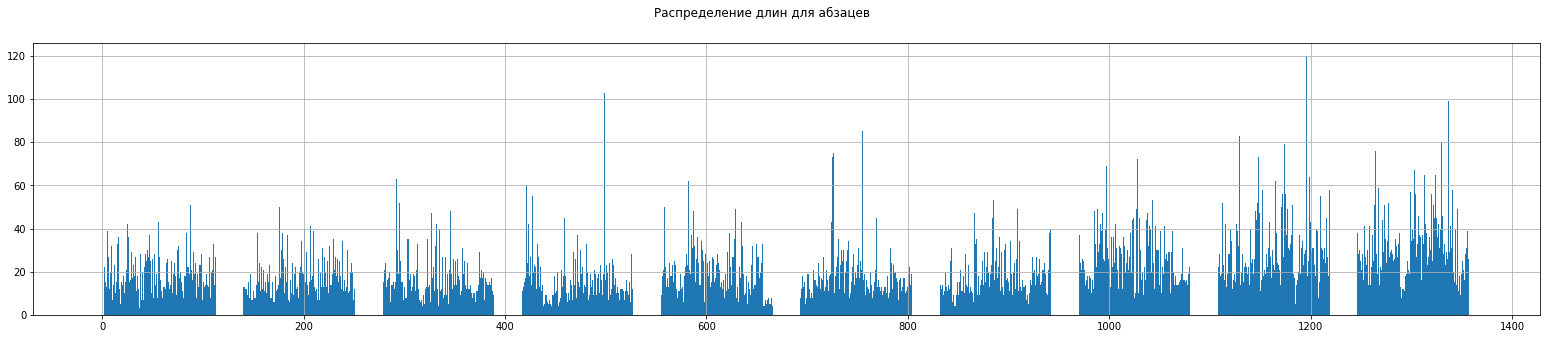

Collections Counter({14: 74, 12: 71, 13: 66, 19: 63, 11: 62, 15: 59, 18: 53, 16: 53, 10: 49, 20: 46, 9: 43, 22: 39, 21: 39, 8: 38, 27: 36, 17: 36, 23: 34, 25: 33, 24: 31, 7: 28, 26: 28, 28: 26, 30: 26, 29: 25, 31: 24, 6: 23, 5: 21, 33: 18, 32: 13, 37: 12, 35: 12, 36: 11, 38: 11, 34: 11, 40: 11, 39: 10, 42: 10, 4: 10, 45: 9, 41: 8, 43: 7, 51: 7, 49: 7, 47: 6, 52: 5, 56: 5, 62: 4, 48: 4, 44: 4, 64: 3, 50: 3, 73: 3, 46: 3, 58: 3, 55: 2, 53: 2, 57: 2, 65: 2, 3: 1, 63: 1, 60: 1, 103: 1, 75: 1, 85: 1, 69: 1, 72: 1, 83: 1, 79: 1, 120: 1, 76: 1, 59: 1, 67: 1, 80: 1, 99: 1})


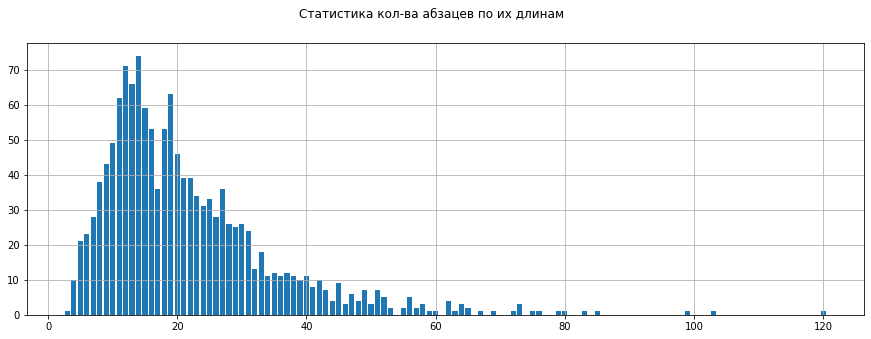

In [150]:
train_counter, train_count = draw_paragraphs_stat(paragraphs_train)

**Во скольких фразах встречается тот или  иной класс**

In [151]:
class_stat(paragraphs_train, tags_train)

Длина массива разметки текста: 1360

Перечень фраз без неклассифицированных лексем:
paragraphs[18] = ['дракон-схема', '—', 'это', 'упорядоченная', 'блок-схема']
tags[18] = ['термин', 'связка', 'связка', 'определение', 'определение']
 
paragraphs[128] = ['keras', '—', 'рекомендуемая', 'библиотека', 'для', 'глубокого', 'изучения', 'python', ',', 'особенно', 'для', 'начинающих']
tags[128] = ['термин', 'связка', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение']
 
paragraphs[165] = ['pythonw.exe', '—', 'исполняемый', 'файл', 'python', 'для', 'приложений', 'с', 'графическим', 'интерфейсом', 'или', 'приложений', 'без', 'интерфейса', 'пользователя']
tags[165] = ['термин', 'связка', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение']
 
paragraphs[167] = ['

### Testing sample

In [152]:
test_paragraphs_amount = 340
ps_test = load_xml('/content/drive/My Drive/Базы/NLP/База_словарей_test_5.xml', test_paragraphs_amount)
print(len(ps_test))

349


In [153]:
paragraphs_test, tags_test, test_colors, max_test_paragraph_len, max_test_paragraph_len_ind  = pars_xml(ps_test)

line 0
line 100
line 200
line 300


In [154]:
if len(test_colors) > colors_count:
  print('В документе цветов разметки больше допустимого')
test_colors # выведем все цвета, которые мы встретили

{'blue',
 'cyan',
 'darkyellow',
 'green',
 'lightgray',
 'magenta',
 'red',
 'white',
 'yellow'}

In [155]:
print(len(paragraphs_test))
print(len(tags_test))

print('Максимальная длина предложения — max_test_paragraph_len =',max_test_paragraph_len)
print('Индекс предложения с максимальной длиной — max_test_paragraph_len_ind =',max_test_paragraph_len_ind)

340
340
Максимальная длина предложения — max_test_paragraph_len = 64
Индекс предложения с максимальной длиной — max_test_paragraph_len_ind = 60


In [156]:
# Корректируем максимальную длину предложения для использования U-net сеток
max_test_paragraph_len = max_paragraph_len

**Извлекаем статистику по абзацам**

In [157]:
paragraphs_test[0]

['удобный',
 'поиск',
 '—',
 'возможность',
 'использования',
 'эффективной',
 'системы',
 'поиска',
 '(',
 'полнотекстовый',
 'поиск',
 ',',
 'одновременный',
 'поиск',
 'в',
 'нескольких',
 'словарях',
 ',',
 'высокая',
 'скорость',
 'поиска',
 ')',
 '[',
 '26',
 ']',
 '.']

In [158]:
tags_test[0]

['термин',
 'термин',
 'связка',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'o',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'дубль-термин',
 'o',
 'o',
 'o',
 'o',
 'o']

In [159]:
paragraphs_test[test_paragraphs_amount - 1]

['аллофоны',
 '–',
 'группа',
 'звуков',
 ',',
 'в',
 'которых',
 'реализуется',
 'данная',
 'фонема',
 ',',
 'конкретная',
 'манифестация',
 'фонемы',
 ':',
 'сама',
 'поймала',
 'сома',
 '[',
 'с¬ма',
 'п¬iмалъ',
 'с¬ма',
 ']',
 '.']

In [160]:
tags_test[test_paragraphs_amount - 1]

['термин',
 'связка',
 'определение',
 'определение',
 'o',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o']

In [161]:
paragraphs_test[max_test_paragraph_len_ind]

['в',
 'рамках',
 'фонетики',
 ',',
 'например',
 ',',
 'слово',
 'часто',
 'определяется',
 'как',
 'группа',
 'звуков',
 ',',
 'которая',
 'объединена',
 'одним',
 'ударением',
 ';',
 'однако',
 'такое',
 'толкование',
 'не',
 'может',
 'быть',
 'признано',
 'успешным',
 ',',
 'поскольку',
 'известны',
 'слова',
 ',',
 'заведомо',
 'единые',
 ',',
 'но',
 'при',
 'этом',
 'характеризующиеся',
 'двумя',
 'ударениями',
 '—',
 'и',
 'в',
 'то',
 'же',
 'время',
 'под',
 'одним',
 'ударением',
 'могут',
 'быть',
 'объединены',
 'целые',
 'участки',
 'речевого',
 'потока',
 ',',
 'порой',
 'существенно',
 'превосходящие',
 'по',
 'размерам',
 'слово',
 '.']

In [162]:
tags_test[max_test_paragraph_len_ind]

['связка',
 'связка',
 'связка',
 'o',
 'o',
 'o',
 'термин',
 'связка',
 'связка',
 'связка',
 'определение',
 'определение',
 'o',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o']

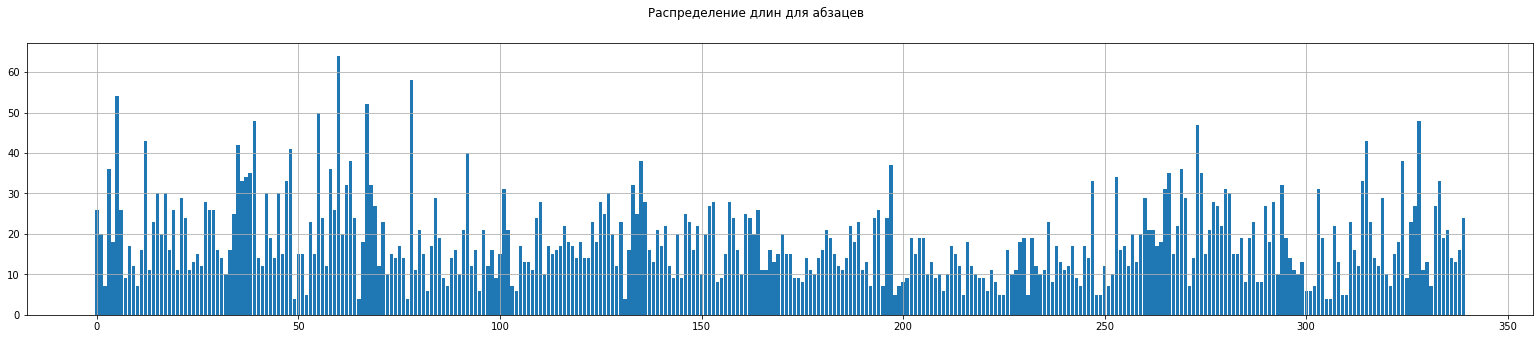

Collections Counter({15: 21, 12: 18, 16: 18, 14: 17, 10: 17, 11: 16, 9: 14, 17: 14, 7: 13, 13: 13, 19: 13, 23: 12, 18: 11, 20: 10, 5: 10, 21: 10, 24: 9, 26: 8, 28: 8, 8: 8, 6: 7, 22: 7, 30: 6, 4: 6, 27: 6, 29: 5, 25: 5, 33: 5, 32: 4, 31: 4, 36: 3, 35: 3, 38: 3, 43: 2, 34: 2, 48: 2, 54: 1, 42: 1, 41: 1, 50: 1, 64: 1, 52: 1, 58: 1, 40: 1, 37: 1, 47: 1})


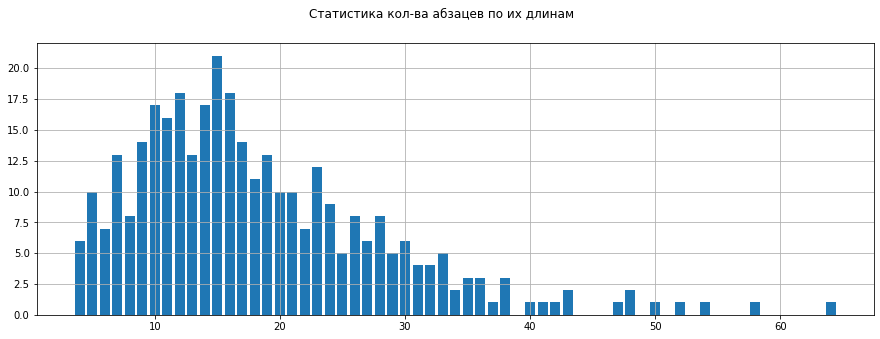

In [163]:
test_counter, test_count = draw_paragraphs_stat(paragraphs_test)

**Во скольких фразах встречается тот или  иной класс**

In [164]:
class_stat(paragraphs_test, tags_test)

Длина массива разметки текста: 340

Перечень фраз без неклассифицированных лексем:
paragraphs[83] = ['длина', 'волны', '—', '{', '\\displaystyle', '{', 'v', '}', '/\\nu', '}', '{', '\\displaystyle', '{', 'v', '}', '/\\nu', '}']
tags[83] = ['термин', 'термин', 'связка', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение']
 
paragraphs[173] = ['сдвиг', 'развернутого', 'набора', 'данных', '—', 'shift', 'the', 'pivoted', 'dataset']
tags[173] = ['термин', 'термин', 'термин', 'термин', 'связка', 'определение', 'определение', 'определение', 'определение']
 
paragraphs[174] = ['сплавка', 'смещенного', 'набора', 'данных', '—', 'melt', 'the', 'shifted', 'dataset']
tags[174] = ['термин', 'термин', 'термин', 'термин', 'связка', 'определение', 'определение', 'определение', 'определение']
 
paragraphs[192] = ['переменные', '-', 'это', 'просто', 

## Preparing a dataset

Объединим обучающий и тестовый массивы, чтобы воспользоваться общим токенизатором.

In [165]:
all_paragraphs = paragraphs_train + paragraphs_test
all_tags = tags_train + tags_test
print(len(all_paragraphs))
print(len(all_tags))

1700
1700


In [166]:
all_paragraphs_together = [' '.join(sequence) for sequence in all_paragraphs]

In [167]:
all_paragraphs_together[max_paragraph_len_ind]

'существительное называет предметы в широком смысле слова ; это — названия вещей ( стол , стена , окно , ножницы , сани ) , лиц ( ребёнок , девочка , юноша , человек ) , веществ ( крупа , сахар , сливки , кислота ) , живых существ и организмов ( кошка , собака , ворона , дятел , окунь , щука , бактерия , вирус , микроб ) , фактов , событий , явлений ( пожар , спектакль , беседа , каникулы , радость ) , географические положения ( россия , байкал , оренбург , европа ) , а также качеств , свойств , действий , состояний ( доброта , синева , бег , решение , толкотня ) .'

In [168]:
all_tags_together = [' '.join(tag) for tag in all_tags]

In [169]:
all_tags_together[max_paragraph_len_ind]

'термин связка определение определение определение определение определение o дубль-связка дубль-связка дубль-определение дубль-определение дубль-связка дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-связка o дубль-определение дубль-связка дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-связка o дубль-определение дубль-связка дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-связка o дубль-определение дубль-определение дубль-определение дубль-определение дубль-связка дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-термин дубль-связка o дубль-определение дубль-определение дубль-определение дубль-определение дубль-определение дубль-связка дубль-термин дубль

In [170]:
num_words = 9000
sent_len = max_paragraph_len 
tokenizer = Tokenizer(num_words, filters=' \t\n', oov_token='<UNK>')

In [171]:
tokenizer.fit_on_texts(all_paragraphs_together)

In [172]:
# реальная длина словаря
len(tokenizer.index_word)

8763

In [173]:
tokenizer.index_word[8302]

'социальная'

In [174]:
tokenizer.index_word

{1: '<UNK>',
 2: ',',
 3: '.',
 4: '—',
 5: ')',
 6: '(',
 7: 'в',
 8: 'и',
 9: 'для',
 10: 'это',
 11: 'с',
 12: 'на',
 13: '}',
 14: '{',
 15: 'или',
 16: '[',
 17: ']',
 18: '-',
 19: ':',
 20: '»',
 21: '«',
 22: 'не',
 23: ';',
 24: 'python',
 25: 'как',
 26: 'является',
 27: 'данных',
 28: 'из',
 29: 'к',
 30: 'x',
 31: 'что',
 32: 'по',
 33: 'программирования',
 34: 'от',
 35: '\\displaystyle',
 36: '–',
 37: 'при',
 38: 'а',
 39: '1',
 40: 'функции',
 41: 'если',
 42: 'англ.',
 43: 'то',
 44: 'которые',
 45: 'который',
 46: 'которая',
 47: 'языка',
 48: '"',
 49: 'библиотека',
 50: 't',
 51: 'времени',
 52: 'также',
 53: '=',
 54: 'объекта',
 55: 'значение',
 56: 'класса',
 57: 'объект',
 58: 'называется',
 59: 'например',
 60: 'его',
 61: 'являются',
 62: 'есть',
 63: 'до',
 64: 'все',
 65: 'за',
 66: 'работы',
 67: 'n',
 68: 'частота',
 69: 'же',
 70: 'число',
 71: 'но',
 72: 'кодом',
 73: 'язык',
 74: 'собой',
 75: 'их',
 76: '2',
 77: 'self',
 78: 'программы',
 79: 'более',

In [175]:
tokenizer.index_word[2]

','

In [176]:
tag_tokenizer = Tokenizer(filters=' ') # colors_count - количество категорий - лучше не указывать, чтобы не потерять категории. Все они автоматически подцедпляются под своими индексами

In [177]:
tag_tokenizer.fit_on_texts(all_tags_together)

In [178]:
tag_tokenizer.index_word # Здесь обращаем внимание, что фактическая нумерация индексов смещена на единицу по сравнению с массивом color_dic

{1: 'o',
 2: 'определение',
 3: 'расшифровка',
 4: 'термин',
 5: 'связка',
 6: 'дубль-термин',
 7: 'дубль-определение',
 8: 'дубль-связка',
 9: 'дубль-расшифровка'}

In [179]:
tag_tokenizer.word_index

{'o': 1,
 'дубль-определение': 7,
 'дубль-расшифровка': 9,
 'дубль-связка': 8,
 'дубль-термин': 6,
 'определение': 2,
 'расшифровка': 3,
 'связка': 5,
 'термин': 4}

In [180]:
len(tag_tokenizer.index_word) # эта величина равна colors_count

9

In [181]:
# prepare color dictionary
tag_tokenizer_dic_color = {}
tag_tokenizer_dic_color[1] = color.END
for i in range(2,10):
  tag_tokenizer_dic_color[i] = dic_color[color_dic[tag_tokenizer.index_word[i]]]
tag_tokenizer_dic_color

{1: '\x1b',
 2: '\x1b\x1b',
 3: '\x1b\x1b',
 4: '\x1b\x1b',
 5: '\x1b\x1b',
 6: '\x1b\x1b',
 7: '\x1b\x1b',
 8: '\x1b\x1b',
 9: '\x1b\x1b'}

In [182]:
# make colored text by dict
def tokens_to_text(x_arr, y_arr, max_len = 0):
  res = '' 
  str_len = 0
  def add_col(col, txt):
    nonlocal res, str_len
    if max_len > 0:
      next_len = len(txt)
      if str_len + next_len > max_len:
        res = res + col + '\n ' + txt
        str_len = next_len + 1
      else:
        res = res + col + ' ' + txt
        str_len += next_len + 1
    else:
      res = res + col + ' ' + txt

  for i, el in enumerate(x_arr):
    if el==0:
      break
    col_ind = y_arr[i].argmax() + 1
    add_col(tag_tokenizer_dic_color[col_ind], tokenizer.index_word[el])

  return res + color.END

**Проверка входящих и исходящих массивов на соответствие их размерностей** 

(для выявления факта порчи данных функцией Tokenizer)

In [183]:
X = tokenizer.texts_to_sequences(all_paragraphs_together)

In [184]:
Y = tag_tokenizer.texts_to_sequences(all_tags_together)

In [185]:
len(X)==len(Y)

True

In [186]:
# Проверка на согласованность входных и выходных данных
for i, elem in enumerate(X):
  if len(Y[i]) != len(X[i]):
    print('X[{}] ='.format(i),X[i])
    print('Y[{}] ='.format(i),Y[i])
    # Если все массивы равны, то здесь  ничего не должно печататься
  else:
    print('len(X[{}]) ='.format(i),len(Y[i]))

len(X[0]) = 25
len(X[1]) = 62
len(X[2]) = 22
len(X[3]) = 15
len(X[4]) = 13
len(X[5]) = 39
len(X[6]) = 27
len(X[7]) = 12
len(X[8]) = 20
len(X[9]) = 32
len(X[10]) = 7
len(X[11]) = 14
len(X[12]) = 23
len(X[13]) = 10
len(X[14]) = 15
len(X[15]) = 33
len(X[16]) = 36
len(X[17]) = 12
len(X[18]) = 5
len(X[19]) = 15
len(X[20]) = 14
len(X[21]) = 18
len(X[22]) = 10
len(X[23]) = 15
len(X[24]) = 21
len(X[25]) = 42
len(X[26]) = 36
len(X[27]) = 15
len(X[28]) = 16
len(X[29]) = 29
len(X[30]) = 17
len(X[31]) = 23
len(X[32]) = 18
len(X[33]) = 27
len(X[34]) = 11
len(X[35]) = 18
len(X[36]) = 12
len(X[37]) = 3
len(X[38]) = 28
len(X[39]) = 7
len(X[40]) = 20
len(X[41]) = 7
len(X[42]) = 22
len(X[43]) = 28
len(X[44]) = 25
len(X[45]) = 30
len(X[46]) = 27
len(X[47]) = 37
len(X[48]) = 25
len(X[49]) = 10
len(X[50]) = 26
len(X[51]) = 8
len(X[52]) = 28
len(X[53]) = 14
len(X[54]) = 19
len(X[55]) = 8
len(X[56]) = 43
len(X[57]) = 27
len(X[58]) = 16
len(X[59]) = 11
len(X[60]) = 8
len(X[61]) = 13
len(X[62]) = 13
len(X[63])

**Выравнивание массивов до максимального размера абзаца**

In [187]:
X = pad_sequences(X, sent_len, padding='post', truncating='post') # заполнение в конце и обрезка с конца предложения

In [188]:
X.shape

(1700, 128)

In [189]:
Y = pad_sequences(Y, sent_len, value=1, padding='post', truncating='post') # заполнение в конце и обрезка с конца предложения

In [190]:
Y.shape

(1700, 128)

In [191]:
Y = to_categorical(Y, colors_count+1)  # см. лекцию "Занятие № 6 Углубленный курс по текстам" https://youtu.be/Nfw7ZY-WzS8?t=1533

In [192]:
Y.shape

(1700, 128, 10)

In [193]:
Y = Y[:, :, 1:]  # см. лекцию "Занятие № 6 Углубленный курс по текстам" https://youtu.be/Nfw7ZY-WzS8?t=1533
Y.shape

(1700, 128, 9)

In [194]:
print(tokens_to_text(X[13], Y[13], 130))

 hash ( x ) - возвращает хеш указанного объекта .


In [195]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=train_paragraphs_len, shuffle=False) # Не перемешиваем данные и берём целую часть на тренировочную выборку

### Total for training and testing samples we have:

In [196]:
print('Xtrain.shape=',Xtrain.shape)
print('Xtest.shape=',Xtest.shape)
print('Ytrain.shape=',Ytrain.shape)
print('Ytest.shape=',Ytest.shape)

Xtrain.shape= (1360, 128)
Xtest.shape= (340, 128)
Ytrain.shape= (1360, 128, 9)
Ytest.shape= (340, 128, 9)


In [197]:
print(tokens_to_text(Xtest[30], Ytest[30], 130))

 закон дисперсии — в физике закон , выражающий зависимость фазовой скорости волны от её частоты .


## Models

**Самописная функция разбивки предсказания по классам** (по аналогии с функцией **classification_report** из библиотеки sklearn)

In [198]:
def class_report(y_true, y_pred, index_word):     # Функция разбивки предсказания по классам
  true = np.argmax(y_true, axis = -1).flatten()   # Преобразуем в вектор токенов из ohe
  # print('true=', true)
  pred = np.argmax(y_pred, axis = -1).flatten()  
  # print('pred=', pred)
  for index, word in index_word.items():          # Проходим по всем классам
    index = int(index) -1
    if index in true:                             
      mask = pred == index                        # Ищем положительные предсказания
      # print('mask=',mask)
      # print('true[mask]=',true[mask])
      # print('pred[mask]=',pred[mask])
      # print('(true[mask] == pred[mask])=',(true[mask] == pred[mask]))
      middle = (true[mask] == pred[mask])
      if middle.any():
        acc = middle.mean()
      else:
        acc = 0
      print('{}  --- {}' .format(word, acc))
    else:
      print('no acc for', word)

In [199]:
emb_size = 128

In [200]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [201]:
model_dir = "/content/drive/My Drive/tmp/"

In [202]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="val_dice_coef",
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        verbose=1
    )
]

**Промежуточные результаты.**

**1)** В показаниях точности обучения нейронных сетех приведена история с несколькими значениями — по мере увеличения и выверки обучающей и тестовой выборки. С момента первого обучения обучающая база увеличена в 4 раза. В результате лучшая архитектура улучшила показатели на 7%, а худшая архитектура улучшила показатели на 9%. Финальный разброс у разных архитектур нейронок составляет 4 %. За время набора обучающего датасета качество распознавания по категориям определительных структур изменилось:
— для базового определения показатели подросли в среднем от 40% до 75%;
— для дублирующего определения показатели подросли в среднем от 5% до 30%, что всё ещё ниже психологического порога в 50%

**2)** В следующей итерации обучение будет разбито на две итерации:
первая - классификация предложений на наличие определительной структуры;
вторая - сегментация предложений с определительными структурами.

Тогда процентные показатели должны стать более точными.

**3)** В планах реализовать обучение с несколькими входными каналами:
1. тип лексемы:
c - кириллический
r - сокращение (кириллица с точкой)
l - латинский
p - символьный, пунктуация
s - символьный, специального назначения (математические, греческие символы)
d - числовой
m - смешанный
u - другой/неизвестный
/w - пробельный/ (под вопросом)
2. части речи и морфологические признаки (из pymorphy)
3. собственно лексемы в нормальной форме

**4)** И напоследок генетическим алгоритмом подобрать архитектуру с наилучшим результатом обучения.

### **Linear segmentation neural network**

### **Recurrent neural network GRU** - Historical progress: 87% -> 92% -> 92.9% -> 93.7% -> 94% -> 95.0%

#### Algorithm: Embedding + Bidirectional(GRU) + GRU , batch_size = 128, activation='softmax' - Historical progress: 87% -> 92% -> 92.9% -> 93.7% -> 94% -> 95.0%

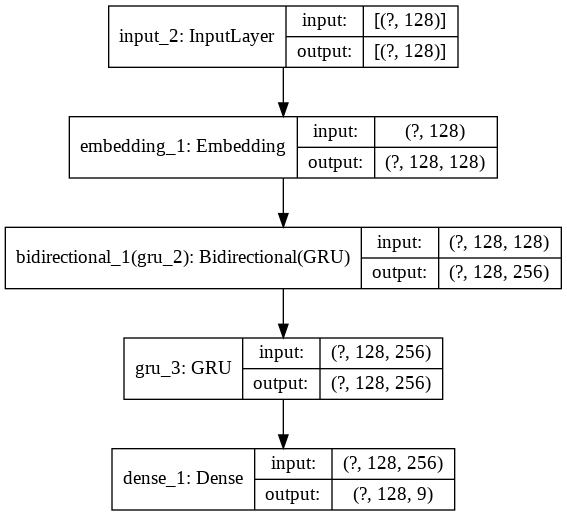

In [203]:
input = Input((sent_len,))
# input = Input(shape=(None,))
x = Embedding(num_words, emb_size)(input)
x = Bidirectional(GRU(emb_size, return_sequences=True))(x)
x = GRU(emb_size * 2, return_sequences=True)(x)
output = Dense(colors_count, activation='softmax')(x)

modelEGRU = Model(input, output)

modelEGRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[dice_coef])
# modelEGRU.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=[dice_coef, AUC(num_thresholds=150)])

plot_model(modelEGRU, show_shapes=True)

In [204]:
historyEGRU = modelEGRU.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(Xtest, Ytest),  
                    callbacks=callbacks_list,
                    verbose=1)
                    
modelEGRU.save( '/content/drive/My Drive/tmp/modelEGRU_100epochs(gl_extr).h5' )

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 1.0472 - dice_coef: 0.5402
Epoch 00001: val_dice_coef improved from -inf to 0.89732, saving model to /content/drive/My Drive/tmp/weights_epoch_1
11/11 [==============================] - 1s 118ms/step - loss: 1.0472 - dice_coef: 0.5402 - val_loss: 0.3972 - val_dice_coef: 0.8973
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.3476 - dice_coef: 0.8683
Epoch 00002: val_dice_coef did not improve from 0.89732
11/11 [==============================] - 0s 43ms/step - loss: 0.3476 - dice_coef: 0.8683 - val_loss: 0.2908 - val_dice_coef: 0.8745
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.3179 - dice_coef: 0.8612
Epoch 00003: val_dice_coef did not improve from 0.89732
11/11 [==============================] - 0s 43ms/step - loss: 0.3179 - dice_coef: 0.8612 - val_loss: 0.2654 - val_dice_coef: 0.8851
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 0.2858 - dice_co

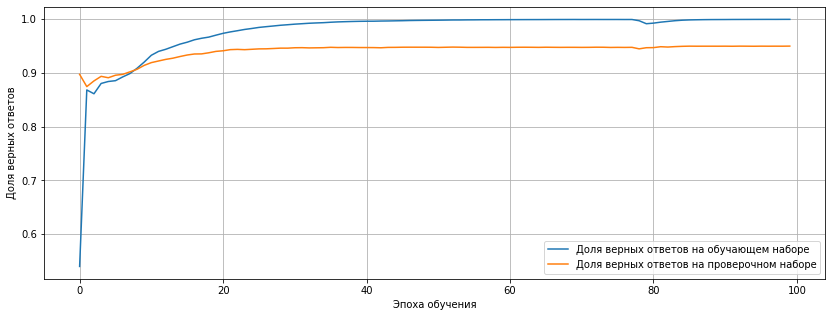

In [205]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyEGRU.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyEGRU.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


**Проверка тренировочной выборки (насколько хорошо выучены примеры)**

In [206]:
YpredEGRU_train = modelEGRU.predict(Xtrain)

In [207]:
for i, el in enumerate(Xtrain):
  print(f'{i+1}.')
  print(tokens_to_text(el, Ytrain[i]))
  print(tokens_to_text(el, YpredEGRU_train[i]))

1.
 декларативное программирование — парадигма программирования , в которой задаётся спецификация решения задачи , то есть описывается , что представляет собой проблема и ожидаемый результат .
 декларативное программирование — парадигма программирования , в которой задаётся спецификация решения задачи , то есть описывается , что представляет собой проблема и ожидаемый результат .
2.
 императивное программирование — это парадигма программирования ( стиль написания исходного кода компьютерной программы ) , для которой характерно следующее : в исходном коде программы записываются инструкции ( команды ) ; инструкции должны выполняться последовательно ; данные , получаемые при выполнении предыдущих инструкций , могут читаться из памяти последующими инструкциями ; данные , полученные при выполнении инструкции , могут записываться в память .
 императивное программирование — это парадигма программирования ( стиль написания исходного кода компьютерной программы ) , для которой характерно следую

**Проверка тестовой выборки (насколько хорошо обучена сеть)**

In [208]:
YpredEGRU_test = modelEGRU.predict(Xtest)

In [209]:
i = 2 + 1
print(f'{i}.')
print(tokens_to_text(Xtest[i], Ytest[i]))
print(tokens_to_text(Xtest[i], YpredEGRU_test[i]))

3.
 парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
 парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .


In [210]:
for i, el in enumerate(Xtest):
  print(f'{i+1}.')
  print(tokens_to_text(el, Ytest[i]))
  print(tokens_to_text(el, YpredEGRU_test[i]))

1.
 удобный поиск — возможность использования эффективной системы поиска ( полнотекстовый поиск , одновременный поиск в нескольких словарях , высокая скорость поиска ) [ 26 ] .
 удобный поиск — возможность использования эффективной системы поиска ( полнотекстовый поиск , одновременный поиск в нескольких словарях , высокая скорость поиска ) [ 26 ] .
2.
 синтаксический анализатор ( жарг. парсер ← англ. parser ) — это программа или часть программы , выполняющая синтаксический анализ .
 синтаксический анализатор ( жарг. парсер ← англ. parser ) — это программа или часть программы , выполняющая синтаксический анализ .
3.
 свойство — необходимое условие принадлежности классу .
 свойство — необходимое условие принадлежности классу .
4.
 парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее пон

In [ ]:
# Предыдущие показания
# class_report(Ytest, YpredEGRU, tag_tokenizer.index_word)

o  --- 0.9742887249736565
расшифровка  --- 0.5585068198133525
определение  --- 0.5717628705148206
термин  --- 0.6327944572748267
связка  --- 0.6320346320346321
дубль-определение  --- 0.3333333333333333
дубль-расшифровка  --- 0
дубль-термин  --- 0.45
дубль-связка  --- 0.2857142857142857


In [ ]:
# # Новые показания
# class_report(Ytest, YpredEGRU, tag_tokenizer.index_word)

o  --- 0.9774891774891775
расшифровка  --- 0.5681946802490097
определение  --- 0.6384567517112633
термин  --- 0.6375838926174496
связка  --- 0.6884615384615385
дубль-определение  --- 0.38333333333333336
дубль-расшифровка  --- 0.6923076923076923
дубль-термин  --- 0.5833333333333334
дубль-связка  --- 0.4482758620689655


In [211]:
# Новые показания
class_report(Ytest, YpredEGRU_test, tag_tokenizer.index_word)

o  --- 0.9837758112094396
определение  --- 0.6918194640338505
расшифровка  --- 0.6194387405886379
термин  --- 0.6768060836501901
связка  --- 0.7322834645669292
дубль-термин  --- 0.5025906735751295
дубль-определение  --- 0.12962962962962962
дубль-связка  --- 0.25
дубль-расшифровка  --- 0


In [212]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredEGRU_test.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.98      0.98      0.98     39351
      определение       0.69      0.69      0.69      1430
      расшифровка       0.62      0.74      0.67      1230
           термин       0.68      0.62      0.65       572
           связка       0.73      0.82      0.78       452
     дубль-термин       0.50      0.35      0.41       279
дубль-определение       0.13      0.06      0.08       126
     дубль-связка       0.25      0.12      0.16        59
дубль-расшифровка       0.00      0.00      0.00        21

         accuracy                           0.95     43520
        macro avg       0.51      0.49      0.49     43520
     weighted avg       0.95      0.95      0.95     43520



In [ ]:
# # NLP - вторая лекция ROC-анализ в задаче классификации
# # https://colab.research.google.com/drive/1vtPbDC3nyxquBQrHLJRRbpVRV1ib-01e?usp=sharing#scrollTo=rKFGwpz-L6af

# plt.figure(figsize=(10,10))

# num_classes = colors_count #узнаем, сколько всего классов
# for i in range(num_classes): #проходимся по всем классам
#   fpr, tpr, thresholds = roc_curve(Ytest[::, i], YpredEGRU[::, i]) #получаем roc-кривую для очередного класса
#   plt.plot(fpr, tpr, label='{} класс - {}, AUC={}'.format(i, dic_color[i], AUC()(Ytest[::, i], YpredEGRU[::, i]))) #отрисовываем кривую и подписываем ее площадь

# avg_fpr, avg_tpr, thresholds = roc_curve(Ytest.flatten(), YpredEGRU.flatten()) #получаем micro-average (общую) кривую roc
# plt.plot(avg_fpr, avg_tpr, 'mD',label='micro-average, AUC={}'.format(AUC()(Ytest, YpredEGRU)))#отрисовываем кривую и подписываем ее площадь
# plt.plot([0,1], [0,1], 'b-.') #обозначим границу качественной работы нейросети
# plt.fill_between([0,1], [0,1], label='Зона некачестванного распознавания', color='pink', alpha=0.3) #обозначим границу некачественной работы нейросети
# plt.legend()

### **One-dimensional convolution** - Historical progress: 85% -> 90% -> 93% -> 93%(улучшение на сотые доли процента) -> 94.2%

#### Алгоритм: Embedding + Conv1D , batch_size = 16, activation='softmax' - Historical progress: 85% -> 90% -> 92% -> 92% -> 93% -> 94.2%

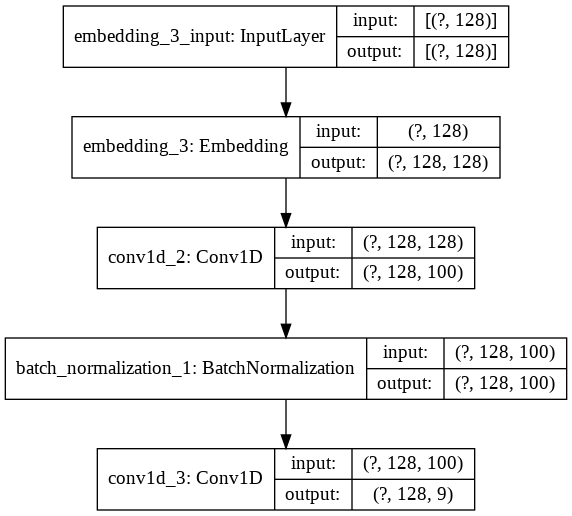

In [215]:
#Создаём сеть с Embedding слоем
modelEC = Sequential()
modelEC.add(Embedding(num_words, emb_size, input_length=sent_len))

modelEC.add(Conv1D(100, 3, activation='relu', padding='same')) #добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 

modelEC.add(BatchNormalization())
modelEC.add(Conv1D(colors_count,3, activation='softmax', padding='same'))

# optimizer='adam'
modelEC.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=[dice_coef])

plot_model(modelEC, show_shapes=True)

In [216]:

#Обучаем сеть
historyEC = modelEC.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=16,
                    validation_data=(Xtest, Ytest))



Epoch 1/100
85/85 [==============================] - 1s 8ms/step - loss: 0.9078 - dice_coef: 0.7270 - val_loss: 0.6884 - val_dice_coef: 0.5565
Epoch 2/100
85/85 [==============================] - 1s 6ms/step - loss: 0.3399 - dice_coef: 0.8978 - val_loss: 0.3947 - val_dice_coef: 0.8574
Epoch 3/100
85/85 [==============================] - 1s 7ms/step - loss: 0.2291 - dice_coef: 0.9288 - val_loss: 0.3852 - val_dice_coef: 0.8902
Epoch 4/100
85/85 [==============================] - 1s 7ms/step - loss: 0.1782 - dice_coef: 0.9492 - val_loss: 0.3766 - val_dice_coef: 0.9029
Epoch 5/100
85/85 [==============================] - 1s 7ms/step - loss: 0.1449 - dice_coef: 0.9643 - val_loss: 0.3593 - val_dice_coef: 0.9104
Epoch 6/100
85/85 [==============================] - 1s 6ms/step - loss: 0.0800 - dice_coef: 0.9736 - val_loss: 0.3524 - val_dice_coef: 0.9130
Epoch 7/100
85/85 [==============================] - 1s 7ms/step - loss: 0.0328 - dice_coef: 0.9826 - val_loss: 0.2832 - val_dice_coef: 0.9258

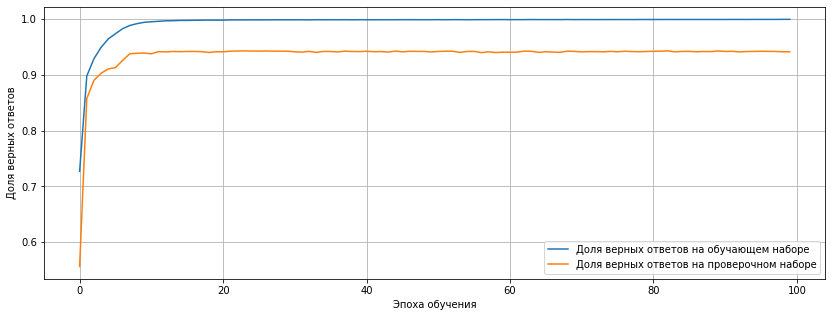

In [217]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyEC.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyEC.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [218]:
YpredEC = modelEC.predict(Xtest)

In [ ]:
# Предыдущее значение
# class_report(Ytest, YpredEC, tag_tokenizer.index_word)

o  --- 0.9596359319351009
расшифровка  --- 0.5236656596173213
определение  --- 0.4959266802443992
связка  --- 0.7019867549668874
термин  --- 0.7110091743119266
дубль-определение  --- 0.16831683168316833
дубль-расшифровка  --- 0.05063291139240506
дубль-термин  --- 0.4576271186440678
дубль-связка  --- 0.22807017543859648


In [ ]:
# # Новые значения
# class_report(Ytest, YpredEC, tag_tokenizer.index_word)

o  --- 0.9659515423204184
расшифровка  --- 0.4942426926483614
определение  --- 0.5516339869281046
термин  --- 0.6309751434034416
связка  --- 0.7300884955752213
дубль-определение  --- 0.1646586345381526
дубль-расшифровка  --- 0.10752688172043011
дубль-термин  --- 0.5074626865671642
дубль-связка  --- 0.2716049382716049


In [219]:
# Новые значения
class_report(Ytest, YpredEC, tag_tokenizer.index_word)

o  --- 0.9765168312840153
определение  --- 0.6408921933085502
расшифровка  --- 0.5398406374501992
термин  --- 0.572347266881029
связка  --- 0.7947598253275109
дубль-термин  --- 0.49640287769784175
дубль-определение  --- 0.12
дубль-связка  --- 0.2
дубль-расшифровка  --- 0


In [220]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredEC.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.98      0.98      0.98     39351
      определение       0.64      0.60      0.62      1430
      расшифровка       0.54      0.44      0.49      1230
           термин       0.57      0.62      0.60       572
           связка       0.79      0.81      0.80       452
     дубль-термин       0.50      0.25      0.33       279
дубль-определение       0.12      0.17      0.14       126
     дубль-связка       0.20      0.19      0.19        59
дубль-расшифровка       0.00      0.00      0.00        21

         accuracy                           0.94     43520
        macro avg       0.48      0.45      0.46     43520
     weighted avg       0.94      0.94      0.94     43520



#### Оборачиваем алгоритм в функцию: **linearSegmentationNet**  - Historical progress: 85% -> 90% -> 93% -> 93% -> 94%

In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - sentence_len - длина предложения
    - num_words - количество слов в словаре
    - embedding_size - длина эмбединга
'''
def linearSegmentationNet(
      num_classes = 9,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 500
      ):
    input = Input((sentence_len,))                                          # Создаем входной слой с размерностью input_shape
    emb = Embedding(num_words, embedding_size)(input)
    x = Conv1D(64, 3, padding='same', name='block1_conv1')(emb) # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv1D(128, 5, padding='same', name='block1_conv2')(x)         # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv1D(num_classes,3, activation=activation_function, padding='same')(x) # Добавляем Conv1D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(input, x)                                             # Создаем модель с входом 'input' и выходом 'x'

    # Компилируем модель
    # model.compile(optimizer=Adam(lr=1e-3),
    model.compile(optimizer='rmsprop', 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model # Возвращаем сформированную модель

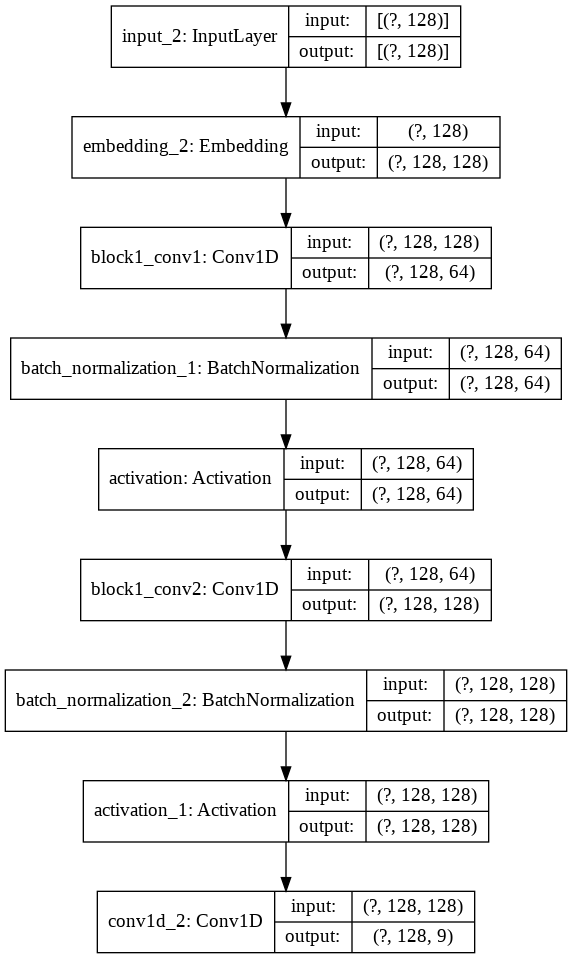

In [ ]:
modelL = linearSegmentationNet(colors_count, sent_len, num_words, 'softmax', emb_size) # Создаем модель linearSegmentationNet
plot_model(modelL, show_shapes=True)

In [ ]:
historyL = modelL.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=16,
                    validation_data=(Xtest, Ytest)) # Обучаем модель на выборке по всем классам

Epoch 1/100
81/81 [==============================] - 1s 10ms/step - loss: 0.3844 - dice_coef: 0.8117 - val_loss: 0.4300 - val_dice_coef: 0.7951
Epoch 2/100
81/81 [==============================] - 1s 8ms/step - loss: 0.1533 - dice_coef: 0.9287 - val_loss: 0.5194 - val_dice_coef: 0.8902
Epoch 3/100
81/81 [==============================] - 1s 8ms/step - loss: 0.0891 - dice_coef: 0.9565 - val_loss: 0.5011 - val_dice_coef: 0.8916
Epoch 4/100
81/81 [==============================] - 1s 8ms/step - loss: 0.0461 - dice_coef: 0.9756 - val_loss: 0.3295 - val_dice_coef: 0.8906
Epoch 5/100
81/81 [==============================] - 1s 8ms/step - loss: 0.0244 - dice_coef: 0.9861 - val_loss: 0.2441 - val_dice_coef: 0.8983
Epoch 6/100
81/81 [==============================] - 1s 8ms/step - loss: 0.0149 - dice_coef: 0.9915 - val_loss: 0.2205 - val_dice_coef: 0.9133
Epoch 7/100
81/81 [==============================] - 1s 8ms/step - loss: 0.0101 - dice_coef: 0.9946 - val_loss: 0.2252 - val_dice_coef: 0.924

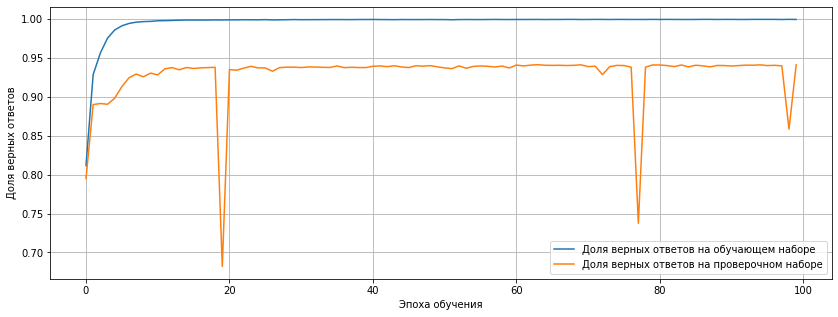

In [ ]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyL.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyL.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
YpredL = modelL.predict(Xtest)

In [ ]:
# Предыдущие показания
# class_report(Ytest, YpredL, tag_tokenizer.index_word)

o  --- 0.9792573714204806
расшифровка  --- 0.552191235059761
определение  --- 0.5172642762284196
термин  --- 0.7270642201834863
связка  --- 0.7032710280373832
дубль-определение  --- 0.21621621621621623
дубль-расшифровка  --- 0.03571428571428571
дубль-термин  --- 0.5409836065573771
дубль-связка  --- 0.3442622950819672


In [ ]:
# # Новые показания
# class_report(Ytest, YpredL, tag_tokenizer.index_word)

o  --- 0.9785828391952996
расшифровка  --- 0.5629569455727051
определение  --- 0.629512349588347
термин  --- 0.6100543478260869
связка  --- 0.6871401151631478
дубль-определение  --- 0.23170731707317074
дубль-расшифровка  --- 0.09042553191489362
дубль-термин  --- 0.44
дубль-связка  --- 0.3673469387755102


In [ ]:
# Новые показания
class_report(Ytest, YpredL, tag_tokenizer.index_word)

o  --- 0.9807645017623432
расшифровка  --- 0.568988173455979
определение  --- 0.6931732933233309
термин  --- 0.6859649122807018
связка  --- 0.7399577167019028
дубль-термин  --- 0.4372093023255814
дубль-определение  --- 0.23275862068965517
дубль-расшифровка  --- 0
дубль-связка  --- 0.1875


In [ ]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredL.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.98      0.98      0.98     36578
      расшифровка       0.57      0.59      0.58      1458
      определение       0.69      0.65      0.67      1421
           термин       0.69      0.70      0.69       558
           связка       0.74      0.78      0.76       448
     дубль-термин       0.44      0.48      0.46       197
дубль-определение       0.23      0.16      0.19       164
дубль-расшифровка       0.00      0.00      0.00        68
     дубль-связка       0.19      0.22      0.20        68

         accuracy                           0.94     40960
        macro avg       0.50      0.51      0.50     40960
     weighted avg       0.94      0.94      0.94     40960



### **U-net** - Historical progress: 89% -> 92%  -> 94.4% -> 94.5% -> 95% -> 96.2%




In [221]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - sentence_len - длина предложения
    - num_words - количество слов в словаре
    - embedding_size - длина эмбединга
'''

def unet(
      num_classes = 6,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 50
      ):
    print('num_classes=',num_classes)
    print('sentence_len=',sentence_len)
    print('num_words=',num_words)
    print('embedding_size=',embedding_size)

    txt_input = Input((sentence_len,))                                         # Создаем входной слой с размерностью input_shape
    print('txt_input=',txt_input.shape)
    emb = Embedding(num_words, embedding_size)(txt_input)
    print('emb=',emb.shape)

    # Block 1
    x = Conv1D(64, 3, padding='same', name='block1_conv1')(emb) # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same', name='block1_conv2')(x)         # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling1D()(block_1_out)                                        # Добавляем слой MaxPooling1D

    # Block 2
    x = Conv1D(128, 3, padding='same', name='block2_conv1')(x)        # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same', name='block2_conv2')(x)        # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling1D()(block_2_out)                                        # Добавляем слой MaxPooling1D

    # Block 3
    x = Conv1D(256, 3, padding='same', name='block3_conv1')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv2')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv3')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling1D()(block_3_out)                                        # Добавляем слой MaxPooling1D

    # Block 4
    x = Conv1D(512, 3, padding='same', name='block4_conv1')(x)        # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv2')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv3')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    # x = Conv1DTranspose(x, 256, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 256 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(256, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv1D(256, 3, padding='same')(x)                             # Добавляем слой Conv1D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    # x = Conv1DTranspose(x, 128, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 128 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(128, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv1D(128, 3, padding='same')(x)                             # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same')(x) # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    # x = Conv1DTranspose(x, 64, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 64 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(64, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = Conv1D(64, 3, padding='same')(x) # Добавляем слой Conv1D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same')(x) # Добавляем слой Conv1D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv1D(num_classes, 3, activation='softmax', padding='same')(x)  # Добавляем Conv1D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(txt_input, x) # Создаем модель с входом 'txt_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

num_classes= 9
sentence_len= 128
num_words= 9000
embedding_size= 128
txt_input= (None, 128)
emb= (None, 128, 128)


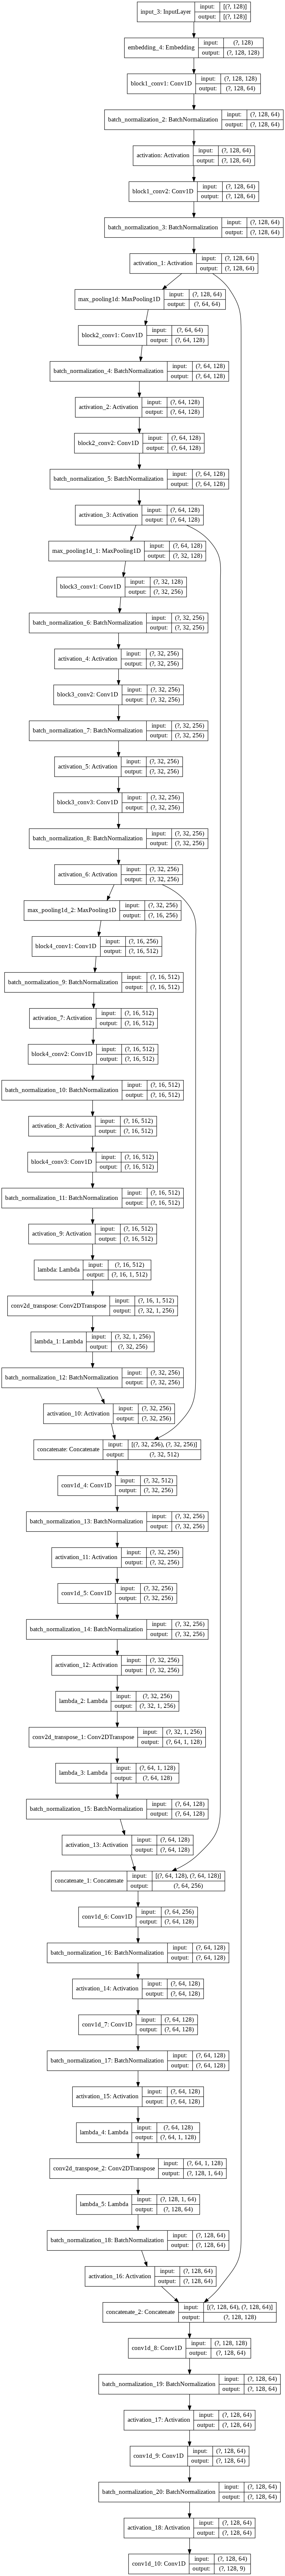

In [222]:
modelUnet = unet(colors_count, sent_len, num_words, 'softmax', emb_size) # Создаем модель unet
plot_model(modelUnet, show_shapes=True)


In [223]:
historyUnet = modelUnet.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=16,
                    validation_data=(Xtest, Ytest),  
                    callbacks=callbacks_list,
                    verbose=1) 
                    
modelUnet.save( '/content/drive/My Drive/tmp/modelUnet_100epochs(gl_extr).h5' )

Epoch 1/100
85/85 [==============================] - ETA: 0s - loss: 0.5842 - dice_coef: 0.7226
Epoch 00001: val_dice_coef did not improve from 0.94983
85/85 [==============================] - 2s 28ms/step - loss: 0.5842 - dice_coef: 0.7226 - val_loss: 0.4931 - val_dice_coef: 0.7925
Epoch 2/100
85/85 [==============================] - ETA: 0s - loss: 0.1750 - dice_coef: 0.9137
Epoch 00002: val_dice_coef did not improve from 0.94983
85/85 [==============================] - 2s 21ms/step - loss: 0.1750 - dice_coef: 0.9137 - val_loss: 0.5683 - val_dice_coef: 0.8934
Epoch 3/100
85/85 [==============================] - ETA: 0s - loss: 0.1051 - dice_coef: 0.9447
Epoch 00003: val_dice_coef did not improve from 0.94983
85/85 [==============================] - 2s 20ms/step - loss: 0.1051 - dice_coef: 0.9447 - val_loss: 0.6226 - val_dice_coef: 0.9019
Epoch 4/100
85/85 [==============================] - ETA: 0s - loss: 0.0622 - dice_coef: 0.9644
Epoch 00004: val_dice_coef did not improve from 0.94

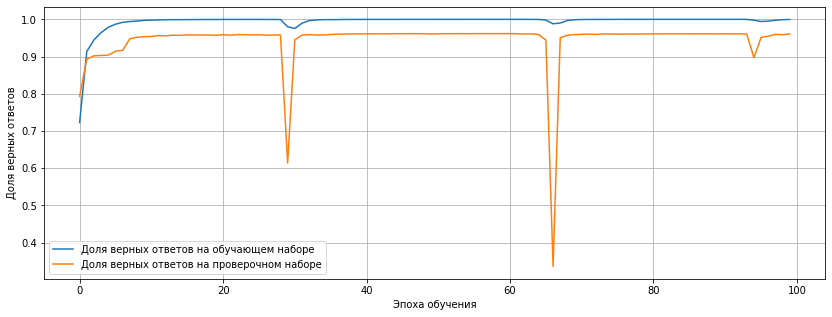

In [224]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyUnet.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyUnet.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [225]:
YpredUnet = modelUnet.predict(Xtest)

In [ ]:
# Прежние показатели
# class_report(Ytest, YpredUnet, tag_tokenizer.index_word)

o  --- 0.9877682403433476
расшифровка  --- 0.6342305037957212
определение  --- 0.671875
термин  --- 0.6079365079365079
связка  --- 0.7755102040816326
дубль-определение  --- 0.33540372670807456
дубль-расшифровка  --- 0
дубль-термин  --- 0.3548387096774194
дубль-связка  --- 0.3050847457627119


In [ ]:
# # Новые показатели
# class_report(Ytest, YpredUnet, tag_tokenizer.index_word)

o  --- 0.9822204125950055
расшифровка  --- 0.633147113594041
определение  --- 0.6695957820738138
термин  --- 0.7238562091503268
связка  --- 0.7309160305343512
дубль-определение  --- 0.42
дубль-расшифровка  --- 0.13157894736842105
дубль-термин  --- 0.6144578313253012
дубль-связка  --- 0.5319148936170213


In [226]:
# Новые показатели
class_report(Ytest, YpredUnet, tag_tokenizer.index_word)

o  --- 0.9874577047345257
определение  --- 0.7950937950937951
расшифровка  --- 0.691358024691358
термин  --- 0.7764932562620424
связка  --- 0.8111587982832618
дубль-термин  --- 0.6368421052631579
дубль-определение  --- 0.208
дубль-связка  --- 0.425
дубль-расшифровка  --- 0


In [227]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredUnet.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.99      0.99      0.99     39351
      определение       0.80      0.77      0.78      1430
      расшифровка       0.69      0.82      0.75      1230
           термин       0.78      0.70      0.74       572
           связка       0.81      0.84      0.82       452
     дубль-термин       0.64      0.43      0.52       279
дубль-определение       0.21      0.21      0.21       126
     дубль-связка       0.42      0.29      0.34        59
дубль-расшифровка       0.00      0.00      0.00        21

         accuracy                           0.96     43520
        macro avg       0.59      0.56      0.57     43520
     weighted avg       0.96      0.96      0.96     43520



**Проверка тестовой выборки (насколько хорошо обучена сеть)**

In [228]:
i = 2
print(f'{i + 1}.')
print(tokens_to_text(Xtest[i], Ytest[i]))
print(tokens_to_text(Xtest[i], YpredUnet[i]))

3.
 свойство — необходимое условие принадлежности классу .
 свойство — необходимое условие принадлежности классу .


In [229]:
for i, el in enumerate(Xtest):
  print(f'{i+1}.')
  print(tokens_to_text(el, Ytest[i]))
  print(tokens_to_text(el, YpredUnet[i]))

1.
 удобный поиск — возможность использования эффективной системы поиска ( полнотекстовый поиск , одновременный поиск в нескольких словарях , высокая скорость поиска ) [ 26 ] .
 удобный поиск — возможность использования эффективной системы поиска ( полнотекстовый поиск , одновременный поиск в нескольких словарях , высокая скорость поиска ) [ 26 ] .
2.
 синтаксический анализатор ( жарг. парсер ← англ. parser ) — это программа или часть программы , выполняющая синтаксический анализ .
 синтаксический анализатор ( жарг. парсер ← англ. parser ) — это программа или часть программы , выполняющая синтаксический анализ .
3.
 свойство — необходимое условие принадлежности классу .
 свойство — необходимое условие принадлежности классу .
4.
 парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее пон

### **Simplified U-net** - Historical progress: 87% -> 91% -> 93.4% -> 93.7%-> 94% -> 95.5%

In [230]:
def simpleUnet(
      num_classes = 9,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 50
      ):
    print('num_classes=',num_classes)
    print('sentence_len=',sentence_len)
    print('num_words=',num_words)
    print('embedding_size=',embedding_size)

    txt_input = Input((sentence_len,))                                         # Создаем входной слой с размерностью input_shape
    print('txt_input=',txt_input.shape)
    emb = Embedding(num_words, embedding_size)(txt_input)
    print('emb=',emb.shape)

    # Block 1
    x = Conv1D(32, 3, padding='same', name='block1_conv1')(emb) # Добавляем Conv1D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(32, 3, padding='same', name='block1_conv2')(x)         # Добавляем Conv1D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling1D()(block_1_out)                                        # Добавляем слой MaxPooling1D

    # Block 2
    x = Conv1D(64, 3, padding='same', name='block2_conv1')(x)         # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same', name='block2_conv2')(x)         # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling1D()(block_2_out)                                        # Добавляем слой MaxPooling1D
    
    # UP 1
    # x = Conv1DTranspose(x, 64, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 64 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(64, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same')(x)                              # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same')(x)                              # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 2
    # x = Conv1DTranspose(x, 32, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 32 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(32, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(32, 3, padding='same')(x)                              # Добавляем Conv1D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(32, 3, padding='same')(x)                              # Добавляем Conv1D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(num_classes,3, activation=activation_function, padding='same')(x) # Добавляем Conv1D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(txt_input, x)                                            # Создаем модель с входом 'txt_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                           # Возвращаем модель

num_classes= 9
sentence_len= 128
num_words= 9000
embedding_size= 128
txt_input= (None, 128)
emb= (None, 128, 128)


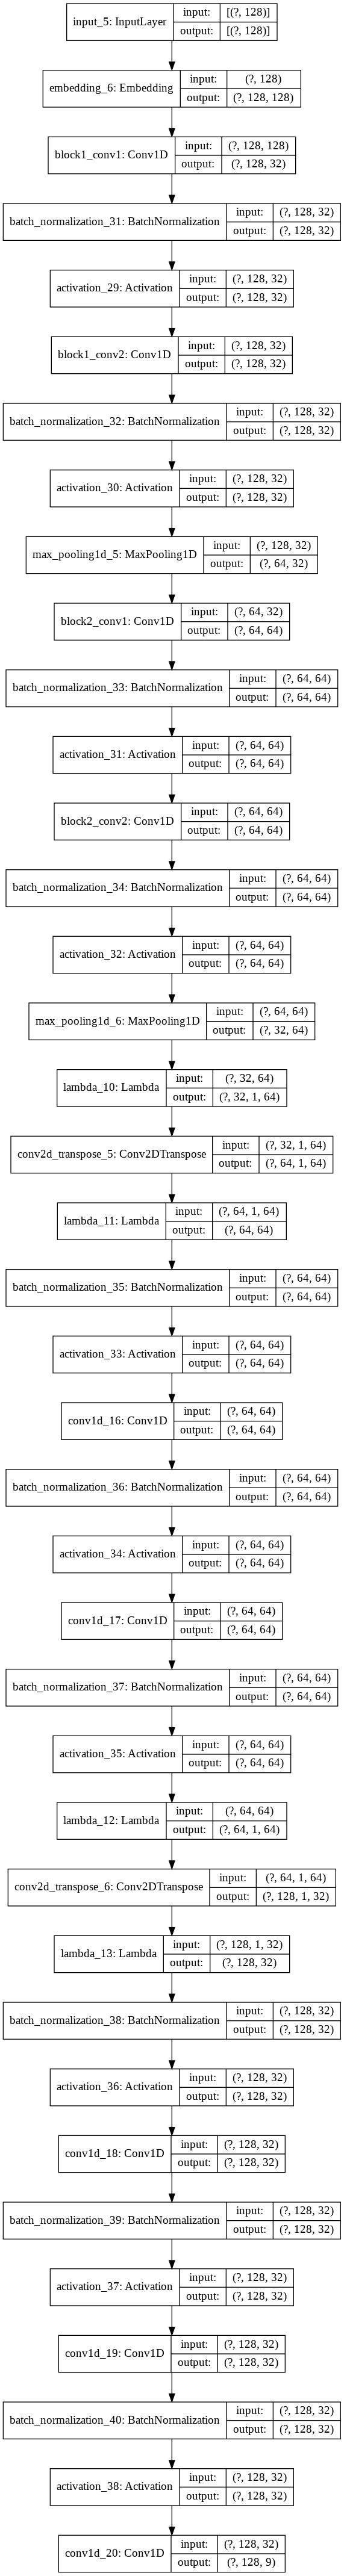

In [232]:
modelS = simpleUnet(colors_count, sent_len, num_words, 'softmax', emb_size) # Создаем модель simpleUnet
plot_model(modelS, show_shapes=True)

In [233]:
historyS = modelS.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=16,
                    validation_data=(Xtest, Ytest)) # Обучаем модель на выборке по трем классам

Epoch 1/100
85/85 [==============================] - 2s 18ms/step - loss: 0.7053 - dice_coef: 0.6468 - val_loss: 0.7546 - val_dice_coef: 0.5447
Epoch 2/100
85/85 [==============================] - 1s 14ms/step - loss: 0.2341 - dice_coef: 0.8808 - val_loss: 0.5100 - val_dice_coef: 0.8451
Epoch 3/100
85/85 [==============================] - 1s 14ms/step - loss: 0.1783 - dice_coef: 0.9129 - val_loss: 0.6105 - val_dice_coef: 0.8951
Epoch 4/100
85/85 [==============================] - 1s 14ms/step - loss: 0.1405 - dice_coef: 0.9314 - val_loss: 0.6162 - val_dice_coef: 0.9000
Epoch 5/100
85/85 [==============================] - 1s 14ms/step - loss: 0.1126 - dice_coef: 0.9434 - val_loss: 0.5546 - val_dice_coef: 0.9022
Epoch 6/100
85/85 [==============================] - 1s 13ms/step - loss: 0.0904 - dice_coef: 0.9533 - val_loss: 0.4350 - val_dice_coef: 0.9049
Epoch 7/100
85/85 [==============================] - 1s 13ms/step - loss: 0.0756 - dice_coef: 0.9601 - val_loss: 0.2944 - val_dice_coef:

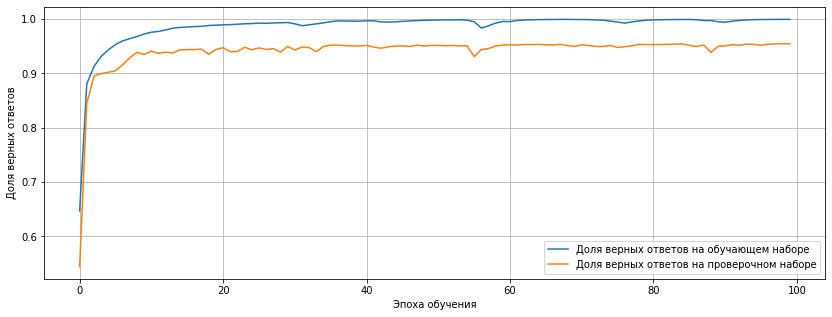

In [234]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyS.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyS.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [235]:
YpredS = modelS.predict(Xtest)

In [ ]:
# Прежние показания
# class_report(Ytest, YpredS, tag_tokenizer.index_word)

o  --- 0.9773731659890401
расшифровка  --- 0.579118028534371
определение  --- 0.6743755781683626
термин  --- 0.7664473684210527
связка  --- 0.8243727598566308
дубль-определение  --- 0.15476190476190477
дубль-расшифровка  --- 0
дубль-термин  --- 0.29
дубль-связка  --- 0.08620689655172414


In [ ]:
# # Новые показания
# class_report(Ytest, YpredS, tag_tokenizer.index_word)

o  --- 0.9727057812164195
расшифровка  --- 0.6243421052631579
определение  --- 0.6991869918699187
термин  --- 0.6901893287435457
связка  --- 0.7364864864864865
дубль-определение  --- 0.3525641025641026
дубль-расшифровка  --- 0.21568627450980393
дубль-термин  --- 0.46534653465346537
дубль-связка  --- 0.46808510638297873


In [236]:
# Новые показания
class_report(Ytest, YpredS, tag_tokenizer.index_word)

o  --- 0.9772298876573927
определение  --- 0.8398950131233596
расшифровка  --- 0.6737692872887583
термин  --- 0.734020618556701
связка  --- 0.8165829145728644
дубль-термин  --- 0.5580110497237569
дубль-определение  --- 0.2
дубль-связка  --- 0.15517241379310345
дубль-расшифровка  --- 0


In [237]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredS.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.98      0.99      0.98     39351
      определение       0.84      0.67      0.75      1430
      расшифровка       0.67      0.75      0.71      1230
           термин       0.73      0.62      0.67       572
           связка       0.82      0.72      0.76       452
     дубль-термин       0.56      0.36      0.44       279
дубль-определение       0.20      0.15      0.17       126
     дубль-связка       0.16      0.15      0.15        59
дубль-расшифровка       0.00      0.00      0.00        21

         accuracy                           0.96     43520
        macro avg       0.55      0.49      0.52     43520
     weighted avg       0.95      0.96      0.95     43520



### **Extended U-net** - Historical progress: 84% -> 90% -> 92% -> 90.5% -> 90.9% -> 92.2%  


In [238]:
def unetWithMask(
      num_classes = 9,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 50
      ):
    print('num_classes=',num_classes)
    print('sentence_len=',sentence_len)
    print('num_words=',num_words)
    print('embedding_size=',embedding_size)

    txt_input = Input((sentence_len,))                                         # Создаем входной слой с размерностью input_shape
    print('txt_input=',txt_input.shape)
    emb = Embedding(num_words, embedding_size)(txt_input)
    print('emb=',emb.shape)

    # Block 1
    x = Conv1D(64, 3, padding='same', name='block1_conv1')(emb) # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same', name='block1_conv2')(x)      # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_1_out
    
    block_1_out_mask = Conv1D(64, 1, padding='same')(block_1_out)  # Добавляем Conv1D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling1D()(block_1_out) # Добавляем слой MaxPooling1D

    # Block 2
    x = Conv1D(128, 3, padding='same', name='block2_conv1')(x)     # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same', name='block2_conv2')(x)     # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv1D(128, 1, padding='same')(block_2_out) # Добавляем Conv1D-маску к текущему слою и запоминаем в переменную block_2_out_mask
    
    x = MaxPooling1D()(block_2_out)                                     # Добавляем слой MaxPooling1D

    # Block 3
    x = Conv1D(256, 3, padding='same', name='block3_conv1')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv2')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv3')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv1D(256, 1, padding='same')(block_3_out) # Добавляем Conv1D-маску к текущему слою и запоминаем в переменную block_3_out_mask
        
    x = MaxPooling1D()(block_3_out)                                     # Добавляем слой MaxPooling1D

     # Block 4
    x = Conv1D(512, 3, padding='same', name='block4_conv1')(x)     # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv2')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv3')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv1D(512, 1, padding='same')(block_4_out) # Добавляем Conv1D-маску к текущему слою и запоминаем в переменную block_4_out_mask
            
    x = MaxPooling1D()(block_4_out)                                     # Добавляем слой MaxPooling1D

    # Block 5
    x = Conv1D(512, 3, padding='same', name='block5_conv1')(x)     # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block5_conv2')(x)     # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block5_conv3')(x)     # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation
    
    for_pretrained_weight = MaxPooling1D()(x)                           # Добавляем слой MaxPooling1D
 
    # UP 1
    # x = Conv1DTranspose(x, 512, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 512 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(512, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv1D(512, 3, padding='same')(x)                          # Добавляем слой Conv1D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same')(x)                          # Добавляем слой Conv1D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 2
    # x = Conv1DTranspose(x, 256, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 256 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(256, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                 # Объединем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv1D(256, 3, padding='same')(x)                          # Добавляем слой Conv1D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same')(x)                          # Добавляем слой Conv1D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 3
    # x = Conv1DTranspose(x, 128, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 128 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(128, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                 # Объединем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv1D(128, 3, padding='same')(x)                          # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same')(x)                          # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 4
    # x = Conv1DTranspose(x, 64, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 64 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(64, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                # Объединем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv1D(64, 3, padding='same')(x)                          # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same')(x)                          # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv1D(num_classes, 3, activation=activation_function, padding='same')(x) # Добавляем Conv1D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(txt_input, x)                                        # Создаем модель с входом 'txt_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                       # Возвращаем сформированную модель

num_classes= 9
sentence_len= 128
num_words= 9000
embedding_size= 128
txt_input= (None, 128)
emb= (None, 128, 128)


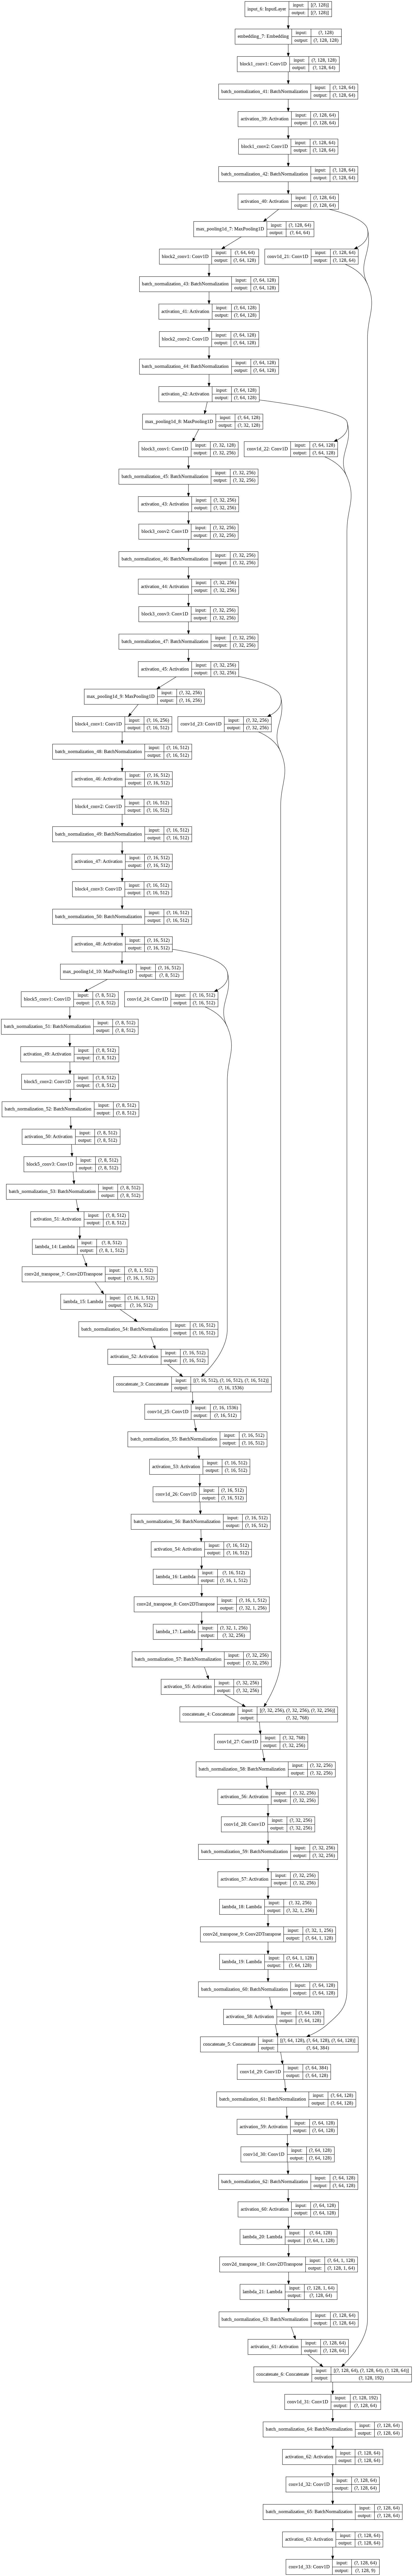

In [239]:
modelM3 = unetWithMask(colors_count, sent_len, num_words, 'sigmoid', emb_size) # Создаем модель unetWithMask
plot_model(modelM3, show_shapes=True)

In [240]:
historyM3 = modelM3.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=64,
                    validation_data=(Xtest, Ytest)) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/100
22/22 [==============================] - 2s 80ms/step - loss: 1.5446 - dice_coef: 0.3456 - val_loss: 1.8522 - val_dice_coef: 0.2499
Epoch 2/100
22/22 [==============================] - 1s 43ms/step - loss: 0.6068 - dice_coef: 0.6345 - val_loss: 1.1196 - val_dice_coef: 0.4694
Epoch 3/100
22/22 [==============================] - 1s 43ms/step - loss: 0.3013 - dice_coef: 0.8003 - val_loss: 0.6933 - val_dice_coef: 0.6660
Epoch 4/100
22/22 [==============================] - 1s 43ms/step - loss: 0.1940 - dice_coef: 0.8724 - val_loss: 0.5442 - val_dice_coef: 0.7731
Epoch 5/100
22/22 [==============================] - 1s 44ms/step - loss: 0.1225 - dice_coef: 0.9107 - val_loss: 0.5199 - val_dice_coef: 0.8211
Epoch 6/100
22/22 [==============================] - 1s 43ms/step - loss: 0.0795 - dice_coef: 0.9278 - val_loss: 0.5344 - val_dice_coef: 0.8487
Epoch 7/100
22/22 [==============================] - 1s 43ms/step - loss: 0.0535 - dice_coef: 0.9346 - val_loss: 0.5624 - val_dice_coef:

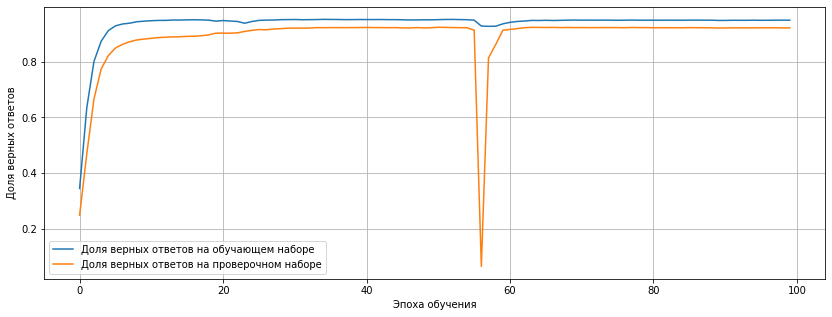

In [241]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyM3.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyM3.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [242]:
YpredM3 = modelM3.predict(Xtest)

In [ ]:
# Прежние показания
# class_report(Ytest, YpredM3, tag_tokenizer.index_word)

o  --- 0.979201184474918
расшифровка  --- 0.6236263736263736
определение  --- 0.721496953872933
термин  --- 0.7370600414078675
связка  --- 0.7587064676616916
дубль-определение  --- 0.3113207547169811
дубль-расшифровка  --- 0.07575757575757576
дубль-термин  --- 0.6037735849056604
дубль-связка  --- 0.43478260869565216


In [ ]:
# # Новые показания
# class_report(Ytest, YpredM3, tag_tokenizer.index_word)

o  --- 0.9824808808374464
расшифровка  --- 0.6303142329020333
определение  --- 0.7138200782268579
термин  --- 0.7684210526315789
связка  --- 0.8126361655773421
дубль-определение  --- 0.2857142857142857
дубль-расшифровка  --- 0.16346153846153846
дубль-термин  --- 0.6593406593406593
дубль-связка  --- 0.36


In [243]:
# Новые показания
class_report(Ytest, YpredM3, tag_tokenizer.index_word)

o  --- 0.9878982843137255
определение  --- 0.7275185936443543
расшифровка  --- 0.6112251882272416
термин  --- 0.7304964539007093
связка  --- 0.7043010752688172
дубль-термин  --- 0.6411764705882353
дубль-определение  --- 0.23880597014925373
дубль-связка  --- 0.3888888888888889
дубль-расшифровка  --- 0


In [244]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredM3.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.99      0.98      0.99     39351
      определение       0.73      0.75      0.74      1430
      расшифровка       0.61      0.73      0.66      1230
           термин       0.73      0.72      0.73       572
           связка       0.70      0.87      0.78       452
     дубль-термин       0.64      0.39      0.49       279
дубль-определение       0.24      0.13      0.17       126
     дубль-связка       0.39      0.24      0.29        59
дубль-расшифровка       0.00      0.00      0.00        21

         accuracy                           0.96     43520
        macro avg       0.56      0.53      0.54     43520
     weighted avg       0.96      0.96      0.96     43520

